# Compare Network Performance
Load in the results from the model trainings, and evaluate their performance

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.benchmark import load_benchmark_data
from sklearn.metrics import mean_absolute_error
from pathlib import Path
from tqdm import tqdm
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

## Load in the Test Data
We are going to use it to validate our models

In [2]:
_, test_data = load_benchmark_data()

In [3]:
baseline_water = (test_data['sol_water'] - test_data['sol_water'].mean()).abs().mean()
print(f'Baseline: {baseline_water:.2f}')

Baseline: 3.28


## Score All Models
Run all models on the test sets, store results in DataFrame

In [4]:
models = glob(os.path.join('networks', '**', 'test_results.csv'), recursive=True)

In [5]:
def score_model(path):
    """Given a log file, parse the settings for the network and the epoch time / ending val_loss
    
    Args:
        path (str): Get the path 
    """
    
    # Get the metadata from the `config.json` file
    path = Path(path)
    with open(path.parent / 'config.json') as fp:
        metadata = json.load(fp)
    metadata['path'] = path.parent
       
    # Score the model on the target variable
    with open(path.parent.parent / 'options.json') as fp:
        options = json.load(fp)
    output = options['output_props']
    metadata['output_variables'] = output
    
    # Load in the log
    log = pd.read_csv(path.parent / 'train_log.csv')
    metadata['epochs'] = len(log)
    metadata['median_epoch_time'] = np.percentile(log['epoch_time'], 50)
    metadata['total_time'] = log['epoch_time'].sum()
    metadata['best_loss'] = log['val_loss'].min()
    metadata['best_loss_epoch'] = log['val_loss'].idxmin()
    
    # Check whether the network had finished training
    metadata['finished'] = os.path.isfile(path.parent.joinpath('finished'))
    
    # Get the scores on the test set
    directory = path.parent
    test_data = pd.read_csv(path)
    pred_cols = [f'{x}_pred' for x in output]
    metadata['mae_all_outputs'] = mean_absolute_error(test_data[pred_cols], test_data[output])

    # Get the MAE on water only
    metadata['mae_water'] = mean_absolute_error(test_data['sol_water_pred'], test_data['sol_water'])
    return metadata

In [6]:
results = [score_model(x) for x in tqdm(models)]

100%|██████████| 32/32 [00:00<00:00, 35.13it/s]


In [7]:
results = pd.DataFrame(results)

In [8]:
results.to_csv('mpnn-results.csv', index=False)

## Evaluate the Models
Make sure that our models are working as expected

In [9]:
results.sort_values('mae_water', ascending=True)[['name', 'mae_water', 'finished', 'total_time',
                                                  'num_epochs', 'batch_size', 'median_epoch_time']].head(10)

,name,mae_water,finished,total_time,num_epochs,batch_size,median_epoch_time
3,dielectric-constant-softplus-charges,0.311397,False,16122.210022,1024,128,49.568679
18,dielectric-constant-softplus-charges_no-acn,0.311420,False,21166.209780,1024,128,48.870527
19,dielectric-constant-softplus-charges_no-acn,0.321039,False,14931.782964,512,128,49.467645
2,dielectric-constant-softplus-charges,0.326877,False,16441.457117,512,128,49.266604
26,dielectric-constant-softplus_no-acn,0.468302,False,17272.847854,1024,128,48.784879
6,single-task-atomic-contrib,0.468612,False,13731.897897,1024,128,49.921906
23,multi-task_no-acn,0.469042,False,27617.203355,1024,128,48.538567
8,dielectric-constant-softplus,0.474221,False,23394.297671,1024,128,49.081242
20,dielectric-constant_no-acn,0.477143,False,12957.373252,512,128,48.694846
25,dielectric-constant-softplus-mpnn-charges_no-acn,0.479680,False,13719.290727,512,128,49.354479


In [10]:
results.sort_values('mae_water', ascending=True).query('num_epochs==512')\
    [['name', 'mae_water', 'finished', 'total_time', 
      'epochs', 'batch_size', 'median_epoch_time']]

,name,mae_water,finished,total_time,epochs,batch_size,median_epoch_time
19,dielectric-constant-softplus-charges_no-acn,0.321039,False,14931.782964,302,128,49.467645
2,dielectric-constant-softplus-charges,0.326877,False,16441.457117,333,128,49.266604
20,dielectric-constant_no-acn,0.477143,False,12957.373252,266,128,48.694846
25,dielectric-constant-softplus-mpnn-charges_no-acn,0.479680,False,13719.290727,278,128,49.354479
7,single-task-atomic-contrib,0.481931,False,14185.844452,282,128,50.305228
27,dielectric-constant-softplus_no-acn,0.483196,False,13215.401819,269,128,49.138069
1,dielectric-constant,0.486686,False,15059.914495,307,128,49.013832
15,single-task,0.487986,False,15469.501307,318,128,48.671924
29,multi-task,0.488920,False,12640.779224,261,128,48.414652
5,dielectric-constant-softplus-gasteiger-charges...,0.490972,False,11489.086980,232,128,49.518228


### Plot the Learning as Function of Epoch
Look for anomalous behavior

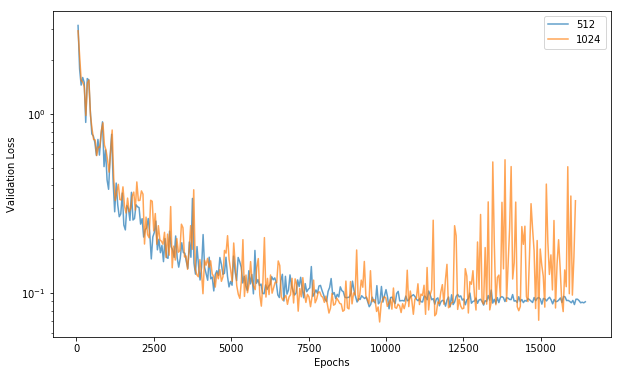

In [11]:
fig, ax = plt.subplots()

for _, f in results.query('name=="dielectric-constant-softplus-charges"').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'train_log.csv'))
    ax.semilogy(log['epoch_time'].cumsum(), log['val_loss'], label=f['num_epochs'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
ax.legend()
fig.set_size_inches(10, 6)

dielectric-constant best loss after 307 epochs was at 179 epochs: 0.22327378392219546
dielectric-constant-softplus-charges best loss after 333 epochs was at 205 epochs: 0.0818239226937294
dielectric-constant-softplus-gasteiger-charges_no-acn best loss after 232 epochs was at 104 epochs: 0.24284909665584564
single-task-atomic-contrib best loss after 282 epochs was at 154 epochs: 0.338492214679718
dielectric-constant-softplus best loss after 512 epochs was at 474 epochs: 0.188337042927742
dielectric-constant-softplus-mpnn-charges best loss after 276 epochs was at 148 epochs: 0.2288961857557297
dielectric-constant-softplus-atomic-contrib best loss after 330 epochs was at 202 epochs: 0.2311808913946152
single-task best loss after 318 epochs was at 190 epochs: 0.32804474234580994
dielectric-constant-softplus-atomic-contrib-featureless best loss after 295 epochs was at 167 epochs: 0.23542506992816925
dielectric-constant-softplus-charges_no-acn best loss after 302 epochs was at 174 epochs: 0.

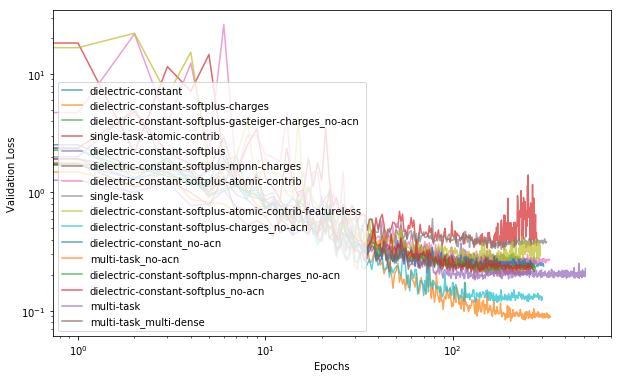

In [12]:
fig, ax = plt.subplots()

for _, f in results.query('num_epochs==512').iterrows():
    log = pd.read_csv(os.path.join(f['path'], 'train_log.csv'))
    print('{} best loss after {} epochs was at {} epochs:'.format(f['name'], len(log), log['val_loss'].idxmin() + 1),
              log['val_loss'].min())
    ax.loglog(log['epoch'], log['val_loss'], label=f['name'], alpha=0.7)

ax.set_ylabel('Validation Loss')
ax.set_xlabel('Epochs')
#ax.set_xlim(0, 2000)
ax.legend()
fig.set_size_inches(10, 6)